In [1]:
import os

DATA_DIR = 'CASIA2/'
print(os.listdir(DATA_DIR))

['Au', 'CASIA 2 Groundtruth', 'Tp']


In [2]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
np.random.seed(2)
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.python.keras.utils.np_utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout,BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import model_from_json
from PIL import Image, ImageChops, ImageEnhance
import PIL
import os
import itertools
from tqdm import tqdm
tf.__version__

'2.12.0'

In [4]:
def ELA(img_path, quality=90):
    TEMP = 'ela_' + 'temp.jpg'
    SCALE = 10
    original = Image.open(img_path)
    diff=""
    try:
        original.save(TEMP, quality=90)
        temporary = Image.open(TEMP)
        diff = ImageChops.difference(original, temporary)
        
    except:
        
        original.convert('RGB').save(TEMP, quality=90)
        temporary = Image.open(TEMP)
        diff = ImageChops.difference(original.convert('RGB'), temporary)
        
       
    d=diff.load()
    WIDTH, HEIGHT = diff.size
    for x in range(WIDTH):
        for y in range(HEIGHT):
            d[x, y] = tuple(k * SCALE for k in d[x, y])
#     save_path = dataset_path +'ELA_IMAGES/'
#     diff.save(save_path+'diff.png')
    return diff

In [5]:
dataset_path='CASIA2/'
path_original = 'Au/'
path_tampered = 'Tp/'
# path_mask='CASIA 2 Groundtruth/'
total_original = os.listdir(dataset_path+path_original)
total_tampered = os.listdir(dataset_path+path_tampered)
# total_mask=os.listdir(dataset_path+path_mask)

In [6]:
pristine_images = []
for i in total_original:
    pristine_images.append(dataset_path+path_original+i)
fake_images = []
for i in total_tampered:
    fake_images.append(dataset_path+path_tampered+i)

In [7]:
len(pristine_images),len(fake_images)

(7492, 5125)

In [8]:
image_size = (224,224)
output_path='../input/preprocessed-ela-images/'

In [9]:
output_path='../input/preprocessed-ela-images/'
if not os.path.exists(output_path+"resized_images/"):
#     os.makedirs(output_path+"resized_images/fake_masks/")
    os.makedirs(output_path+"resized_images/fake_images/")
    os.makedirs(output_path+"resized_images/pristine_images/")
    height = 224
    width = 224
#     p2=output_path+"resized_images/fake_masks/"
    p1=output_path+"resized_images/fake_images/"
    p3=output_path+"resized_images/pristine_images/"
    j=0
    for fake_image in tqdm(total_tampered):
        try:
            if(j%1):
                j+=1
                continue
            img=Image.open(dataset_path+path_tampered + fake_image).convert("RGB")
            img = img.resize((height, width), PIL.Image.ANTIALIAS)
            img.save(p1+fake_image)
            j+=1
        except:
            print("Encountered Invalid File : ",fake_image)
        
    j=0
    for pristine_image in tqdm(total_original):
        try:
            if(j%1):
                j+=1
                continue
            img=Image.open(dataset_path+path_original + pristine_image).convert("RGB")
            img = img.resize((height, width), PIL.Image.ANTIALIAS)
            img.save(p3+pristine_image)
            j+=1
        except:
            print("Invalid File : " ,pristine_image)
        
        
        
else:
    print('images resized,path exists')

images resized,path exists


In [10]:
resized_fake_image_path=output_path+"resized_images/fake_images/"
resized_pristine_image_path=output_path+"resized_images/pristine_images/"
resized_fake_image=os.listdir(resized_fake_image_path)
resized_pristine_image=os.listdir(resized_pristine_image_path)

In [11]:
len(resized_fake_image), len(resized_pristine_image)

(5122, 7491)

In [12]:
ela_images_path=output_path+'ELA_IMAGES/'
ela_real=ela_images_path+'Au/'
ela_fake=ela_images_path+'Tp/'
if not os.path.exists(ela_images_path):
    os.makedirs(ela_images_path)
    os.mkdir(ela_real)
    os.mkdir(ela_fake)
    j=0
    for i in tqdm(resized_fake_image):
        ELA(resized_fake_image_path+i).save(ela_fake+i)
        j+=1
        if(j==15000):
            break
    j=0
    for i in tqdm(resized_pristine_image):
        ELA(resized_pristine_image_path+i).save(ela_real+i)
        j+=1
        if(j==15000):
            break
else:
    print('Images are already converted to ELA')

Images are already converted to ELA


In [13]:
X=[]
Y=[]
j=0
for file in tqdm(os.listdir(ela_real)):
    img=Image.open(ela_real+file)
    img=np.array(img)
    X.append(img)
    Y.append(0)
    j+=1
    if(j==15000):
        break
j=0
for file in tqdm(os.listdir(ela_fake)):
    img=Image.open(ela_fake+file)
    img=np.array(img)
    X.append(img)
    Y.append(1)
    j+=1
    if(j==15000):
        break

100%|█████████████████████████████████████████████████████████████████████████████| 5123/5123 [00:09<00:00, 543.55it/s]


In [14]:
X=np.array(X)
X.shape

(12614, 224, 224, 3)

In [15]:
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

x_train, x_dev, y_train, y_dev = train_test_split(X, Y, test_size=0.2, random_state=133,shuffle=True)
y_train=to_categorical(y_train,2)
y_dev=to_categorical(y_dev,2)
print(len(x_train), len(y_train))
print(len(x_dev), len(y_dev))

10091 10091
2523 2523


In [16]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
def CNN():
    model = Sequential()
    model.add(Conv2D(filters=128,kernel_size=(5,5),activation='relu',input_shape=(224,224,3)))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Conv2D(filters=256,kernel_size=(5,5),activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Flatten())
    model.add(Dense(units=64,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(units=16,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(units=2,activation='softmax'))
    return model

In [17]:
model1=CNN()
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 220, 220, 128)     9728      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 128)    0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 106, 106, 256)     819456    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 53, 53, 256)      0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 719104)            0         
                                                                 
 dense (Dense)               (None, 64)                4

In [18]:
epochs = 5
batch_size = 32
init_lr = 1e-4

optimizer = tf.keras.optimizers.legacy.Adam(learning_rate = init_lr, decay = init_lr/epochs)

model1.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

In [19]:
import keras

early_stop = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=6,verbose=1,restore_best_weights=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.22, patience = 6, verbose = 1, 
                                              min_delta = 0.0001,min_lr=0.0001)

In [20]:
hist = model1.fit(x_train,y_train,
                 epochs = epochs,
                validation_data = (x_dev,y_dev),
                callbacks = [early_stop,reduce_lr],
                verbose=1,shuffle=True)

Epoch 1/5
316/316 [==============================] - 9111s 29s/step - loss: 1.3729 - accuracy: 0.6878 - val_loss: 0.4879 - val_accuracy: 0.8308 - lr: 1.0000e-04
Epoch 2/5
316/316 [==============================] - 2800s 9s/step - loss: 0.5558 - accuracy: 0.7666 - val_loss: 0.4724 - val_accuracy: 0.8315 - lr: 1.0000e-04
Epoch 3/5
316/316 [==============================] - 2945s 9s/step - loss: 0.4954 - accuracy: 0.7983 - val_loss: 0.4139 - val_accuracy: 0.8391 - lr: 1.0000e-04
Epoch 4/5
316/316 [==============================] - 2990s 9s/step - loss: 0.4446 - accuracy: 0.8209 - val_loss: 0.4048 - val_accuracy: 0.8518 - lr: 1.0000e-04
Epoch 5/5
316/316 [==============================] - 4701s 15s/step - loss: 0.3908 - accuracy: 0.8439 - val_loss: 0.3898 - val_accuracy: 0.8581 - lr: 1.0000e-04


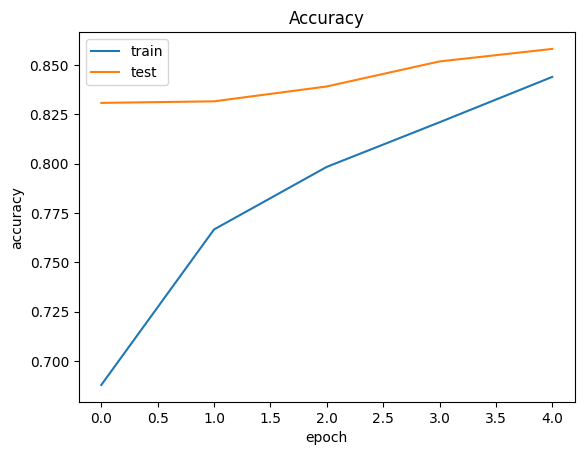

In [21]:
import matplotlib.pyplot as plt
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title("Accuracy")
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train','test'])
plt.show()

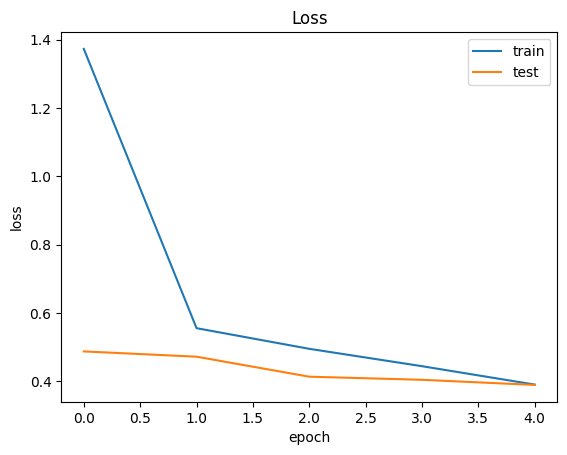

In [22]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("Loss")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','test'])
plt.show()

In [23]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
   
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

79/79 [==============================] - 236s 3s/step


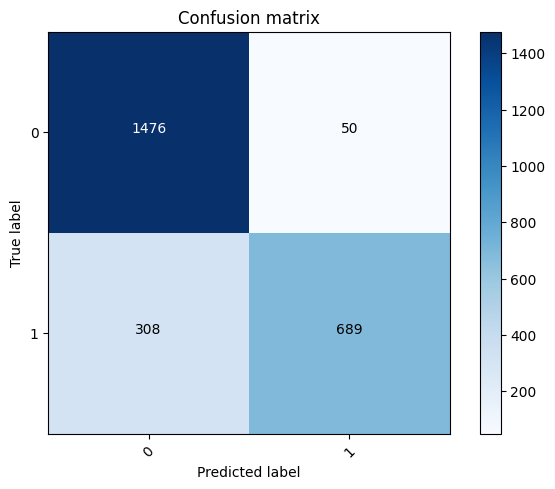

In [24]:
Y_pred = model1.predict(x_dev)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(y_dev,axis = 1) 
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
plot_confusion_matrix(confusion_mtx, classes = range(2))

In [25]:
from sklearn.metrics import classification_report
print(classification_report(Y_true, Y_pred_classes))

              precision    recall  f1-score   support

           0       0.83      0.97      0.89      1526
           1       0.93      0.69      0.79       997

    accuracy                           0.86      2523
   macro avg       0.88      0.83      0.84      2523
weighted avg       0.87      0.86      0.85      2523
